In [1]:
import pugna.layers

In [2]:
import pugna.activations

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

mpl.rcParams.update({"font.size": 16})

In [4]:
def plot_history(history, labels):
    plt.figure()
    for i, h in enumerate(history):
        loss = h.history["loss"]
        plt.plot(range(len(loss)), loss, label=labels[i])
    plt.yscale("log")
    plt.title('train')    
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    if "val_loss"  in history[0].history.keys():
        plt.figure()
        for h in history:
            loss = h.history["val_loss"]
            plt.plot(range(len(loss)), loss, ls='--')
        plt.yscale("log")
        plt.title('validation')

# generate train, test data

In [5]:
# equation 29 of 1910.11710
def gen_test_data(npts=100, nscale=0):
    # x = np.linspace(-np.pi/2., np.pi/2., 100)
    # y = np.cos(10*x) + np.sin(5*x)
    x = np.linspace(-1, 1, npts)
    y = np.cos(50*x) + np.sin(5*x)

    n = np.random.normal(0, scale=nscale, size=y.shape)

    return x[:,np.newaxis], (y+n)[:,np.newaxis]

In [120]:
x, y = gen_test_data(npts=100, nscale=0.2)

In [121]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [122]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(75, 1)
(25, 1)
(75, 1)
(25, 1)


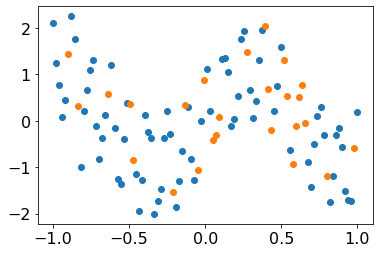

In [123]:
plt.figure()
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)

# setup ANN

In [128]:
def build_and_fit_ExU_model(
    x,
    y,
    verbose=False,
    batch_size=None,
    epochs=1000,
    units=1000,
    lr=0.001,
    validation_data=None
):
    if batch_size is None:
        batch_size = x.shape[0]

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
    model.add(pugna.layers.ExU(units))
#     model.add(tf.keras.layers.Dense(units, activation="relu"))
#     model.add(tf.keras.layers.Dense(units, activation="relu"))
    model.add(tf.keras.layers.Dense(units))
    model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
    model.add(tf.keras.layers.Dense(units))
    model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    # optimizer = tf.keras.optimizers.Adam(lr)
    optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipnorm=0.5)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipvalue=5.0)
    #optimizer = tf.keras.optimizers.Nadam(lr)
    # optimizer = tf.keras.optimizers.SGD(lr)
    model.compile(loss="mse", optimizer=optimizer)

    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)

    return history, model

In [131]:
%%time
history1, model1 = build_and_fit_ExU_model(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))

CPU times: user 1min 4s, sys: 10.1 s, total: 1min 14s
Wall time: 31.7 s


In [126]:
%%time
history2, model2 = build_and_fit_ExU_model(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))

CPU times: user 1min 2s, sys: 4.91 s, total: 1min 7s
Wall time: 30.5 s


In [127]:
%%time
history3, model3 = build_and_fit_ExU_model(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))

CPU times: user 1min 1s, sys: 4.91 s, total: 1min 6s
Wall time: 29.9 s


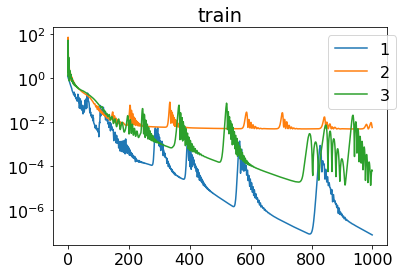

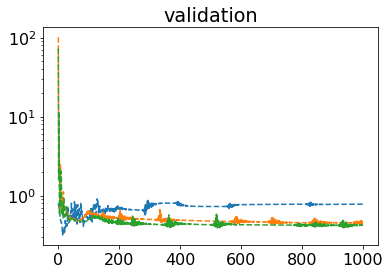

In [132]:
plot_history([history1, history2, history3], labels=['1', '2', '3'])

In [133]:
yhat1 = model1.predict(x_train)
yhat2 = model2.predict(x_train)
yhat3 = model3.predict(x_train)

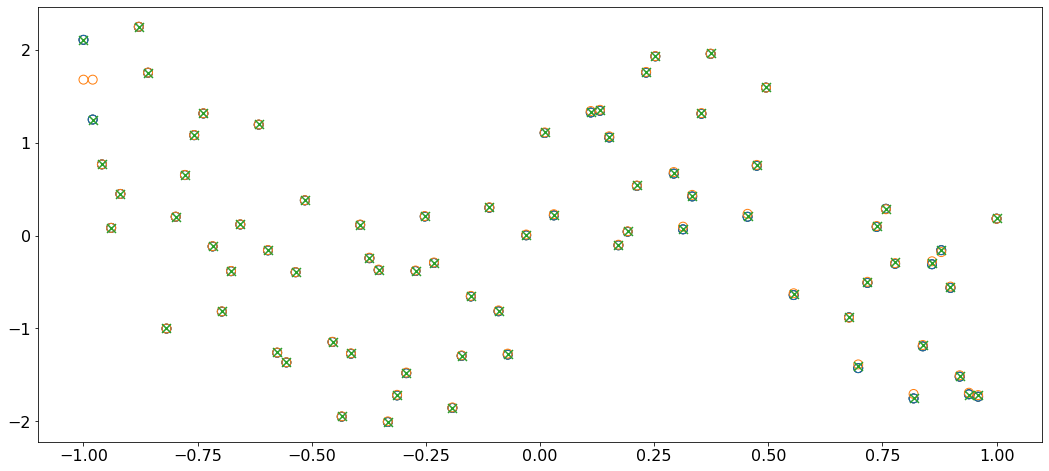

In [134]:
plt.figure(figsize=(18, 8))
plt.scatter(x_train, y_train, facecolors='none', edgecolors='k', s=80)
plt.scatter(x_train, yhat1, facecolors='none', edgecolors='C0', s=80)
plt.scatter(x_train, yhat2, facecolors='none', edgecolors='C1', s=80)
plt.scatter(x_train, yhat3, c='C2', marker='x', s=80)

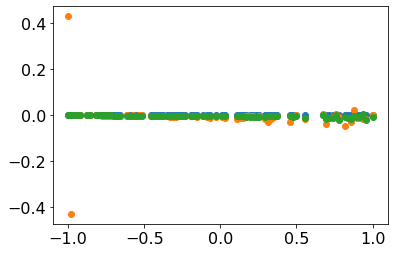

In [135]:
plt.figure()
plt.scatter(x_train, y_train-yhat1)
plt.scatter(x_train, y_train-yhat2)
plt.scatter(x_train, y_train-yhat3)

(1e-07, 0.4534644985650029)

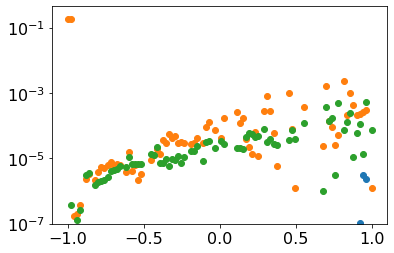

In [136]:
plt.figure()
plt.scatter(x_train, tf.keras.losses.mse(y_train, yhat1))
plt.scatter(x_train, tf.keras.losses.mse(y_train, yhat2))
plt.scatter(x_train, tf.keras.losses.mse(y_train, yhat3))
plt.yscale('log')
plt.ylim(1e-7)